# Chapter 2 - Categorization of Text by summary

In this chapter, we will run a first categorization of the HP fanfiction English dataset based on the tropes found in the summary of each story. 

To identify the tropes, we will use the technique of Bag of Words and N-grams, to identify words which are the most important.

The goal is to be able to identify common tropes from the HP fanfiction world like '8th year', 'Mariage Law', 'Marauders', etc. The aim is to complete the current categorization done by the author with more hp-specific thematics.

A lot of the code is inspired from *Blueprints for Text Analytics using Python*, Jens Albrecht, Sidharth Ramachandran, Christian Winkler, O'Reilly, 2020, which can be found here : https://github.com/blueprints-for-text-analytics-python/blueprints-text

# Table of Content

- Settings
- Text Pre-Processing
- Word Frequency Analysis

# Settings

## Python settings & Importing the libraries 
Import the basic librairies : numpy, pandas, matplotlib, spacy, etc. Define the default settings for pandas and matplotlib

In [1]:
BASE_DIR = ".."
%run "$BASE_DIR/settings.py"

## Importing the Dataset
We will work with the English subset of the HP fanfiction dataset

In [21]:
pd.options.display.max_colwidth = 180 ###
#file = "$BASE_DIR/data/English-presentation-dataset/hpclean_engl.csv.gz"
file = f"{BASE_DIR}/data/English-presentation-dataset/hpclean_engl.csv.gz" #location of the file
df = pd.read_csv(file, index_col = 0,
                parse_dates = ["Published", "Updated"], infer_datetime_format = True #will identify the dates to do time analysis
                )
df.sample(5, random_state=53)

,Chapters,Favs,Follows,Published,Reviews,Updated,Words,author,characters,genre,language,rating,story_link,synopsis,title,published_mmyy,pairing
587150,1,1.00,3.00,2006-02-03,1.00,NaN,622,reviews,"Hermione G., Ron W.",NaN,English,T,https://www.fanfiction.net/s/2783366/1/The-Sevenths-of-Year-Seven,Ron and Hermione. Intermittent moments on the Horcrux search.,The Sevenths of Year Seven,2-2006,"Hermione G., Ron W."
20320,96,61.00,48.00,2018-12-30,48.00,4/9/2019,346390,girlfromkerteh,"Sirius B., Remus L., James P., Peter P.",Angst/Romance,English,M,https://www.fanfiction.net/s/13162705/1/No-Such-Thing-As-Normal,"Forming the Marauders was the best thing that happened to all four of them, they lived for the camaraderie. But friendship doesn't come without a few misunderstandings, secrets...",No Such Thing As Normal,12-2018,NaN
582614,1,NaN,NaN,2006-03-06,2.00,NaN,182,reviews,"Remus L., Sirius B.",NaN,English,K,https://www.fanfiction.net/s/2832277/1/Long-Black-Hair,A poem about Remus mourning Sirius after the fall through the veil.,Long Black Hair,3-2006,"Remus L., Sirius B."
199722,3,71.00,71.00,2013-05-27,14.00,12/6/2014,4264,Unspeakable Phoenix,"Harry P., Daphne G.",Adventure/Romance,English,M,https://www.fanfiction.net/s/9332263/1/Hidden-Secrets,"Summary: Harry is a mega powerful wizard, still good though with Slytherin friends. Harry gets resorted in fourth year and is secretly dating Daphne until his fourteenth birthd...",Hidden Secrets,5-2013,NaN
48268,1,30.00,31.00,2017-11-17,4.00,3/5/2018,1906,reviews,"[Tom R. Jr., OC] Severus S.",Romance/Adventure,English,T,https://www.fanfiction.net/s/12728541/1/His-Most-Faithful,"Instead of a child to defeat the Dark Lord, what if Fate send a child to help him win the war? Divini Le Fay made her journey to Hogwarts and later becomes the Dark Lord's most...",His Most Faithful,11-2017,"Tom R. Jr., OC"


## Data Preparation
### Column names standardization

In [24]:
# Changing the column names to simplify the analysis : removing capital letters and labeling "summary" as "text"
df.columns = ['chapters', 'favs', 'follows', 'published', 'reviews', 'updated',
       'words', 'author', 'characters', 'genre', 'language', 'rating',
       'story_link', 'text', 'title', 'published_mmyy', 'pairing']

### Checking Missing Data

In [22]:
df.isna().sum()

Chapters               0
Favs               56502
Follows           108186
Published              0
Reviews            40723
Updated           322008
Words                  0
author                 0
characters         51657
genre              48073
language               0
rating                 0
story_link             0
synopsis              10
title                 14
published_mmyy         0
pairing           201460
dtype: int64

We will remove text with no summary nor title, since they will get problematic during our analysis.

In [5]:
df['text'].dropna(inplace = True)
df['title'].dropna(inplace = True)

## Checking Types

In [23]:
df.dtypes

Chapters                   int64
Favs                     float64
Follows                  float64
Published         datetime64[ns]
Reviews                  float64
Updated                   object
Words                      int64
author                    object
characters                object
genre                     object
language                  object
rating                    object
story_link                object
synopsis                  object
title                     object
published_mmyy            object
pairing                   object
dtype: object

In [27]:
df[['text', 'title']] = df[['text', 'title']].astype('str')

# Text Preprocessing

## Tokenization with regular expression

In [8]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

## Treating Stop Words

In [9]:
import nltk
# not in book: make sure stop words are available
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pauli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
import nltk

stopwords = set(nltk.corpus.stopwords.words('english'))

In [11]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

Select the type of stop words to include or not in the list : this action depends heavily on the type of dataset. At a first analysis, we will not add any stop words but we may add this information later on.

In [12]:
include_stopwords = {''}
exclude_stopwords = {'against'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

## Processing a Pipeline with one Line of Code

In [13]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [28]:
df['tokens'] = df['text'].progress_apply(prepare, pipeline=pipeline)

100%|██████████| 506057/506057 [01:01<00:00, 8253.87it/s] 


# Analysing word Frequency

In [15]:
from collections import Counter ###
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].progress_map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [34]:
freq_df = count_words(df)
freq_df.head(10)

100%|██████████| 506057/506057 [00:06<00:00, 77580.35it/s]


,freq
token,
harry,183954
hermione,103467
one,81663
draco,77793
hogwarts,63975
potter,60048
year,53544
story,50236
love,49870


## Frequency Diagram

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

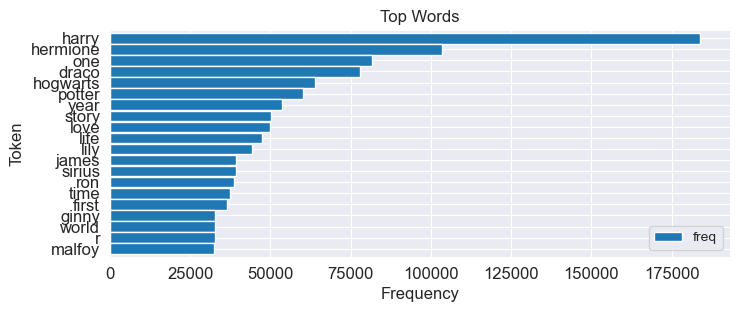

In [18]:
ax = freq_df.head(20).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

## Word Cloud

In [19]:
from wordcloud import WordCloud ###
from collections import Counter ###

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

We will create a word cloud between the different years of published work to see if there is an evolution in time.

100%|██████████| 25437/25437 [00:00<00:00, 80823.27it/s]


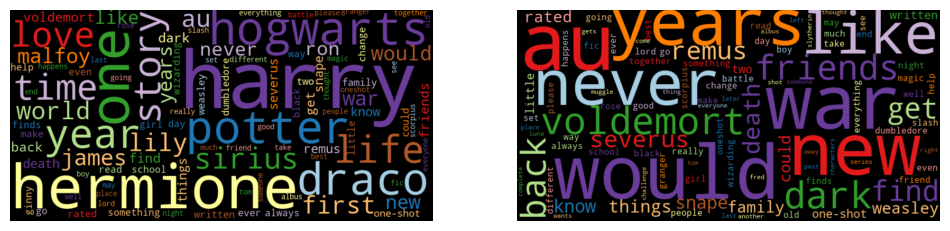

In [30]:
#identifying the years
df["year"] = df["published"].dt.year

# creating two wordcloud with and without most used words for year 2015
freq_2015_df = count_words(df[df['year']==2015])
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_2015_df['freq'], max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_2015_df['freq'], max_words=100, stopwords=freq_df.head(20).index)
#plt.tight_layout()###


## Ranking with TF-IDF

In [31]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].progress_map(update)

    # create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [32]:
idf_df = compute_idf(df)

100%|██████████| 506057/506057 [00:09<00:00, 56005.26it/s]


In [41]:
# high IDF means rare (interesting) term
idf_df.sample(20)

,df,idf
token,,
mongrel,3,12.14
morrighan,2,12.54
diluted,5,11.62
saturday,249,7.72
abusing,61,9.12
potterhead,42,9.50
owing,16,10.46
after-party,7,11.29
mcbride,14,10.60


In [35]:
# not in book: for more data: joining is faster
freq_df = freq_df.join(idf_df)
freq_df['tfidf'] = freq_df['freq'] * freq_df['idf']

100%|██████████| 25437/25437 [00:00<00:00, 78655.43it/s]


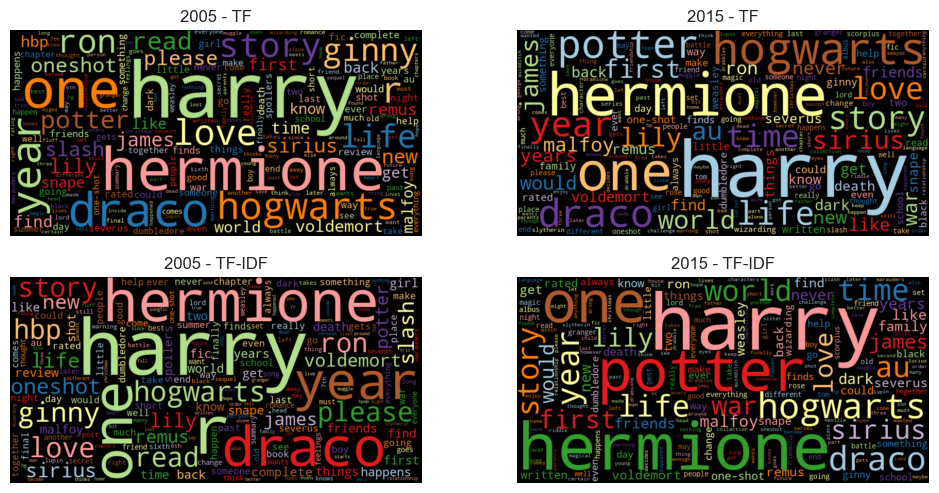

In [40]:
# Comparing term frequency and tf-idf on two different years 
freq_2005 = count_words(df[df['year'] == 2005])
freq_2015 = count_words(df[df['year'] == 2015])

freq_2005['tfidf'] = freq_2005['freq'] * idf_df['idf']
freq_2015['tfidf'] = freq_2015['freq'] * idf_df['idf']

plt.figure(figsize=(12,6)) ###
#wordcloud(freq_df['freq'], title='All years', subplot=(1,3,1))
plt.subplot(2,2,1)###
wordcloud(freq_2005['freq'], title='2005 - TF', 
          stopwords=[])
plt.subplot(2,2,2)###
wordcloud(freq_2015['freq'], title='2015 - TF', 
          stopwords=[])
plt.subplot(2,2,3)###
wordcloud(freq_2005['tfidf'], title='2005 - TF-IDF', 
          stopwords=[])
plt.subplot(2,2,4)###
wordcloud(freq_2015['tfidf'], title='2015 - TF-IDF', 
          stopwords=[])

There doesn't seem to be any difference in terms of themes between the years. Tf-Idf doesn't make any difference at this scale since the characters are a key aspect of the summary.

## Analysing N-Grams

In [42]:
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords])==0]

In [43]:
df['bigrams'] = df['text'].progress_apply(prepare, pipeline=[str.lower, tokenize]) \
                          .progress_apply(ngrams, n=2, stopwords=stopwords)

count_words(df, 'bigrams').head(10)

100%|██████████| 506057/506057 [00:06<00:00, 83973.83it/s]


,freq
token,
harry potter,36006
draco malfoy,16416
r r,14520
one shot,11944
hermione granger,10959


In [44]:
idf_df = compute_idf(df) ### re-initialize to be safe
# concatenate existing IDF data frame with bigram IDFs
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams', min_df=10)])

freq_df = count_words(df[df['year'] == 2015], 'bigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

100%|██████████| 25437/25437 [00:00<00:00, 173044.10it/s]


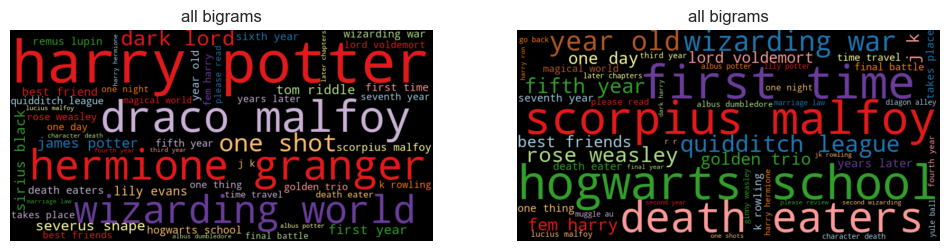

In [49]:
plt.figure(figsize=(12,6)) ###
plt.subplot(1,2,1) ###
wordcloud(freq_df['tfidf'], title='all bigrams', max_words=50)

plt.subplot(1,2,2) ###
# plt.tight_layout() ###
wordcloud(freq_df['tfidf'], title='bigrams without most frequent', max_words=50, stopwords=freq_df.head(15).index )

In order to have a better view of the fanfiction themes outside of the characters, we will include in the pre-processing the removal of the characters name.

In [50]:
df['trigrams'] = df['text'].progress_apply(prepare, pipeline=[str.lower, tokenize]) \
                          .progress_apply(ngrams, n=3, stopwords=stopwords)

count_words(df, 'trigrams').head(10)

100%|██████████| 506057/506057 [00:04<00:00, 111560.28it/s]


,freq
token,
please r r,4969
r r please,1867
j k rowling,1800
full summary inside,1280
second wizarding war,749
harry potter characters,646
rating may change,645
quidditch league fanfiction,627
james sirius potter,597


In [51]:
idf_df = compute_idf(df) ### re-initialize to be safe
# concatenate existing IDF data frame with bigram IDFs
idf_df = pd.concat([idf_df, compute_idf(df, 'trigrams', min_df=10)])

freq_df = count_words(df[df['year'] == 2015], 'trigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

100%|██████████| 25437/25437 [00:00<00:00, 109645.12it/s]


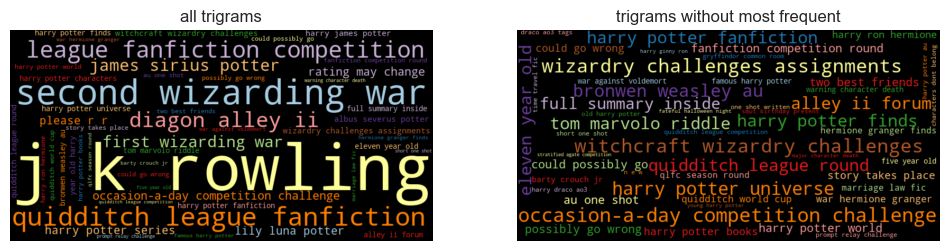

In [52]:
plt.figure(figsize=(12,6)) ###
plt.subplot(1,2,1) ###
wordcloud(freq_df['tfidf'], title='all trigrams', max_words=50)

plt.subplot(1,2,2) ###
# plt.tight_layout() ###
wordcloud(freq_df['tfidf'], title='trigrams without most frequent', max_words=50, stopwords=freq_df.head(15).index )

# Removing the characters name for better theme identification

## Analysing themes by stories genre

In [53]:
#tip : use the request str.contains to analyse genre like "romance" or "humour"